# [NML-24] Assignment 2: Graph Neural Networks

TAs: [William Cappelletti](https://people.epfl.ch/william.cappelletti) and [Abdellah Rahmani](https://people.epfl.ch/abdellah.rahmani)

## Students

* Team: `1`
* Students: `Nikolaos Efthymiou`, `Aristotelis Dimitriou`

In [ ]:
# from google.colab import drive
# drive.mount("/NML")

# %cd ../NML/MyDrive/NML_A2

## Instructions

**!! Read carefully before starting !!**

**Deadline:** April 30

**Grading:**
* The integrality of Assignment 2 will be scaled to 100% and will amount to 1/3 of the overall assignments score.
* The total number of points is **100**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable or function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored.

* You cannot import any other library than we imported, unless explicitly stated.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTex-equations

## Objective

This assignment focuses on Graph Neural Networks. In the first part, you will load and prepare data using the PyTorch Geometric library. Next, you will define a GNN used to solve a task. You will train and test the Neural Network and comment on the results.
In the second part, you will define a new GNN block, in order to include it in the previous architecture.
The third part is theoretical and study a way to include structural properties in learned networks.

## Prerequisites

The additional [tutorial notebook](nml24_gnn_tutorial.ipynb) provides a broad overview of PyTorch and PyTorch Geometric, showing how to manipulate tensors and train neural networks and GNNs.

The following resources might help you familiarize with PyTorch and PyTorch geometric.

* [PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)
* [PyTorch geometric: Official tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html#official-examples)


## Part 0: Explore the data [0 points]

This part contains no questions, but we will go together through the data to get a feeling of their content.
We work with the [GitHub dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.GitHub.html), from the ["Multi-scale Attributed Node Embedding"](https://arxiv.org/abs/1909.13021) paper.
In this dataset, nodes represent developers on GitHub and edges are mutual follower relationships. It contains 37,300 nodes, 578,006 edges, 128 node features and 2 classes.

This data is readily available in PyTorch Geometric, let's start by installing it.

In [1]:
!pip install torch_geometric -q
!pip install pyg_lib -f https://data.pyg.org/whl/torch-2.2.0+cu121.html -q
!pip install torchmetrics -q


[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib

[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Then, we can import all relevant libraries. Some of them will be useful in later steps.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric as pyg
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.datasets import GitHub
from torchmetrics import Metric
from torchmetrics.classification import Accuracy, BinaryF1Score, Precision, Recall

C:\Users\arist\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Let's download the data.

In [3]:
dataset = GitHub(".")
data = dataset._data

Now, we shall study its content. Node attributes are accessible through the `x` attribute, which is a `torch.Tensor`.

In [4]:
print("Design matrix")
n_nodes, n_feats = data.x.shape
print(f"Num. nodes: {n_nodes}; num features: {n_feats}")

Design matrix
Num. nodes: 37700; num features: 128


We see that we have 37,700 nodes, each with 128 features. The features correspond to an embedding of location, starred repositories, employer and e-mail address of each user.

Each node comes with a 0/1 label, which indicates whether it corresponds to a web, or a machine learning developer.

In [5]:
print("Target vector")
print("First five elements:", data.y[:5])
print("Number of samples:", data.y.shape)
print("Number of nodes in class 1:", data.y.sum().item())

Target vector
First five elements: tensor([0, 0, 1, 0, 1])
Number of samples: torch.Size([37700])
Number of nodes in class 1: 9739


We see that the task is quite imbalanced, as class one is underrepresented. To get more meaningful interpretations, we swap classes zero and one.

In [6]:
data.y = 1 - data.y

The edges are contained in the `edge_index` attribute, which is again a tensor. Let's check its shape.

In [7]:
print("Edge index shape:", data.edge_index.shape)

Edge index shape: torch.Size([2, 578006])


**0.1 [0 points]** Describe the content of the edge index matrix and how it relates to the adjacency matrix.

**Your answer here:**

**Answer Nikos**

The edge index matrix $M$ is essentially a sparse representation of the adjacency matrix. Each column $e$ corresponds to a directed edge $(i,j)$ and $e=[i,j]^T$. Thus, $M$ contains the indices of the non-zero elements of the adjacency matrix. In our case, we have undirected edges and thus the columns of $M$ come in pairs (every undirected edge is replaced by its two directed counterparts).

**Answer Aristotelis**

The edge index matrix lists pairs of connected nodes, with each column representing an edge (source and destination nodes). This is essentially a sparse representation of the adjacency matrix.

Now, we will create two random binary masks on the nodes: one for training and one for testing. We would like to have 70% of the samples in the training split, so we will uniformly pick nodes with that probability.

We use a masking strategy instead of directly splitting the data because our interpretation of the task is that we have a social network in which the training label are accessible, while the test nodes, even though available, are unknown. This simplifies the sampling strategy, in particular for network methods, as we do not have to worry about loosing structure.

In [8]:
rng = torch.Generator().manual_seed(452)
train_mask = torch.randn(n_nodes, generator=rng) < 0.8

n_nodes_tr = train_mask.sum().item()
print(f"Training set size: {n_nodes_tr} ({n_nodes_tr / n_nodes:.2%})")
print(f"Test set size: {n_nodes - n_nodes_tr} ({1 - n_nodes_tr / n_nodes:.2%})")
print(
    f"Ratio of class 1 in training: {torch.sum(train_mask * data.y).item() / n_nodes_tr:.2%}"
)

Training set size: 29636 (78.61%)
Test set size: 8064 (21.39%)
Ratio of class 1 in training: 74.12%


We saw that the graph has 37,700 nodes, which means that the dense adjacency matrix has 1,421,290,000 entries.
Supposing that binary variables are stored in a single bit, this would still require ~170 MB to store. With 8bit integers or floats it would occupy more than 10 GB, but with mainly zero values.

Since each node can fit in 16 bits, this representation can fit in 2.2 MB.

## Part 1: Deep learning on graph data [45 points]

This part presents a general workflow for deep learning and our recommended libraries: PyTorch and PyTorch Geometric.
We will start with classical ML baselines, to get some robust results to which we can compare. Then we will introduce Network features, to see whether they can help in our task. Finally, we start working with deep learning, and graph neural networks.

### Question 1.1: Our first baseline (4 points)

In this question we define a baseline model with a "classical" ml method, namely a random forest, to get an idea of what performances we can expect from the following models.
This model will only use node features, so it does not leverage at all the graph structure.

**1.1.1 [2pts]** Train a random forest classifier based on the node features. Make sure to use the provided `train_mask` for both the features and the target labels.

In [ ]:
# Your solution here ###########################################################

X_train = data.x[train_mask]
y_train = data.y[train_mask]

X_test = data.x[~train_mask]
y_test = data.y[~train_mask]

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf_classifier.fit(X_train, y_train)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.1.2 [1pts]** Predict the labels of the test nodes, then print the `classification_report`.

In [ ]:
# Your solution here ###########################################################

y_pred = rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.1.3 [1pt]** Discuss which of the metrics is the most informative one for our setting.

**Your answer here:**

The most informative metric in this context is the F1-score since we are dealing with imbalanced data (class 0: 27961, class 1: 9739). The F1-score is good since it balances both precision and recall through a harmonic mean $\left(\text{hmean}(a,b) = \frac{a\cdot b}{a + b}\right)$, ensuring that false positives and false negatives are taken into consideration.

### Question 1.2: Graph baseline - Laplacian eigenmaps (5 points)

Now, let's implement a second benchmark, this time relying on structural properties. We would like to use eigenmaps of the Laplacian, but if you try to do it you would quickly run out of memory! (Go ahead and try if you will 😉)

The adjacency matrix is too big to use it in computations, but it would be mainly filled with zeros. We can optimize memory and running time by using a **sparse representation**.

**1.2.1 [1pts]** Compute the Laplacian matrix as a [sparse SciPy array][scipy_sparse]. Start by creating a sparse adjacency matrix form the `edge_index`, supposing that all edge weights are 1.

[scipy_sparse]: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [ ]:
# Your solution here ###########################################################

adjacency = pyg.utils.to_scipy_sparse_matrix(data.edge_index).tocsr()

degrees = adjacency.sum(axis=1).A.flatten()
degree_matrix = sparse.diags(degrees)
laplacian = degree_matrix - adjacency

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.2.2 [1pts]** Use SciPy sparse linear algebra capabilities to compute the first 5 nontrivial eigenvectors of the Laplacian.

*Note: This takes ~15 minutes, so you can change the condition to False after completing Question 1.2 to iterate more quickly over the following ones.

In [ ]:
# Your solution here ###########################################################

if True:  # Change to True to run cell

    eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=6, which='SM')
    eigvecs = eigenvectors[:, 1:6] # The first one is the trivial eigenvale, eigenvector pair

    for i in range(6):
        print(f"{eigenvalues[i] = }, {eigenvectors[:, i] = }")

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

else:
    eigvecs = np.random.rand(n_nodes, 5)

**1.2.3 [1pts]** Train and test a new random forest classifier using the eigenvector representation as features.

In [ ]:
# Your solution here ###########################################################

X_features = eigvecs
labels = data.y.numpy()

X_train = X_features[train_mask]
y_train = labels[train_mask]
X_test = X_features[~train_mask]
y_test = labels[~train_mask]

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.2.4 [1pts]** Now, combine the two sets of features, i.e. the given programmers features and the Laplacian eigenmaps, into a single design matrix, then train and test another RF.

In [ ]:
# Your solution here ###########################################################

combined_features = np.hstack((data.x.numpy(), eigvecs))

X_train = combined_features[train_mask]
y_train = labels[train_mask]
X_test = combined_features[~train_mask]
y_test = labels[~train_mask]

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.2.5 [1pts]** Comment on the results and describe which model you expect to perform the best on unseen dataset.



**Your answer here:**

**First Baseline (Node based):**

High accuracy, good precision and recall for class 1, but lower for class 0.

$\rightarrow$ Difficulty identifying the minority class.

**Second Baseline (L Eigenvectors based):**

Lower accuracy, high recall for class 1, but very low for class 0.

$\rightarrow$ Difficulty identifying the minority class.

**Third Baseline (Combination):**

High accuracy, improvement in balance of the recall between the two classes.

$\rightarrow$ Better generalization.

**Conclusion**

We can conclude that the **third model** which generalizes well across both classes is expected to perform better on unseen data.

### Question 1.3: Neural Network baseline - MLP (16 points)

In this question, we move from classical ML to deep learning and, again, we start from a simple model to get a viable benchmark.

**1.3.1 [2pts]** Create two `DataLoaders`, for the training and test data respectively, by using the `TensorDataset` class. Use the predefined batch size and shuffle training data.

References:
- [Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [PyTorch data utility](https://pytorch.org/docs/stable/data.html)

In [30]:
batch_size = 128

# Your solution here ###########################################################

X_train_tensor = data.x[train_mask]
y_train_tensor = data.y[train_mask]
X_test_tensor = data.x[~train_mask]
y_test_tensor = data.y[~train_mask]

# SHOULD WE NOT USE THE COMBINED FEATURES?
#  Then use:
#   data.x[train_mask] and data.y[train_mask] for training
#   data.x[~train_mask] and data.x[~train_mask] for testing

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.2 [2pts]** Define a [torch module][nn_module] for a two-layer perceptron with the ReLU activation function. The hidden dimension will be a parameter of the constructor function.
This neural network will take as input a design matrix and predict the "logits" of class 1.

[nn_module]: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [31]:
class MLP(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_features: int, hidden_features: int):
      super(MLP, self).__init__()
      self.layer1 = nn.Linear(in_features, hidden_features)
      self.relu = nn.ReLU()
      self.layer2 = nn.Linear(hidden_features, 2)

    def forward(self, x):
      x = self.layer1(x)
      x = self.relu(x)
      x = self.layer2(x)
      return x
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.3 [1pts]** Define a function to perform one training step for a given NN, taking as argument a batch of data `x` with target `y`, an [optimizer](torch_optim), and a [loss function](torch_loss). The function should return the loss value, as a float.

In [32]:
def train_nn_step(
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    # My parameters #
    is_gcn: bool=False,
    edge_idx=None
    #################
) -> float:
    model.train()  # Used to ensure that relevant blocks are in training mode

    # Your solution here #######################################################
    optimizer.zero_grad()

    if is_gcn:
      y_pred = model(x, edge_idx)
    else:
      y_pred = model(x)

    loss = loss_fn(y_pred, y)

    loss.backward()

    optimizer.step()

    return loss.item()
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.4 [2pts]** Write an evaluation function that takes as input a PyTorch Module, a data loader, and a [TorchMetrics function][torchmetrics] and returns the cumulative metric over all batches.

[TorchMetrics][torchmetrics] is a convenient package that implements metrics that work with PyTorch Tensors, and also with batched data.

[torchmetrics]: https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html

In [33]:
def eval_nn(model: nn.Module, loader: DataLoader, metric_fn: Metric) -> float:
    model.eval()  # Used to ensure that relevant block are in evaluation model

    # Your solution here #######################################################
    with torch.no_grad():
      for sample in loader:
        input, label = sample
        input.to(device)
        label.to(device)

        output = model(input.to(device))
        _, pred = torch.max(output, dim=1)

        metric_fn(pred.to(device), label.to(device))

    metric = metric_fn.compute()

    metric_fn.reset()

    return metric
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.5 [2pts]** Create an instance of the previously defined MLP, a relevant [loss function][torch_loss] for our classification task, and an [optimizer](torch_optim).
When needed, as for the MLP hidden dimension and optimizer learning rate, select parameters that provide good results for the task. You might need some trial-and-error, so keep track of you results as you will be asked to comment on those hyperparameters.

Make sure to send everything to the correct device at initialization, as moving information from the CPU to the GPU is time-consuming.
To use GPUs, you might have to change runtime type.

[torch_loss]: https://pytorch.org/docs/stable/nn.html#loss-functions
[torch_optim]: https://pytorch.org/docs/stable/optim.html


In [35]:
print(f"Using {device} device")

# Your solution here ###########################################################

in_features = n_feats
hidden_features = 256   # Optimal values
learning_rate = 1e-4    # Optimal values

mlp = MLP(in_features=in_features, hidden_features=hidden_features).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using cpu device


**1.3.6 [3pts]** Perform 10 epochs of training. During each epoch, you should perform training steps iterating over the whole dataset. Gather the losses of each batch, and plot the evolution of the training loss at the end.

Epoch 1/15, Average Loss: 0.506618769389802
Epoch 2/15, Average Loss: 0.3876231090518935
Epoch 3/15, Average Loss: 0.35837096464017343
Epoch 4/15, Average Loss: 0.3496493029183355
Epoch 5/15, Average Loss: 0.34492332982862817
Epoch 6/15, Average Loss: 0.341296199259573
Epoch 7/15, Average Loss: 0.3386089970068685
Epoch 8/15, Average Loss: 0.33609528987315196
Epoch 9/15, Average Loss: 0.333432462516016
Epoch 10/15, Average Loss: 0.3315200624537879
Epoch 11/15, Average Loss: 0.3288464259741635
Epoch 12/15, Average Loss: 0.3264441768927821
Epoch 13/15, Average Loss: 0.3240181524948827
Epoch 14/15, Average Loss: 0.3215802638181325
Epoch 15/15, Average Loss: 0.31942145089650975


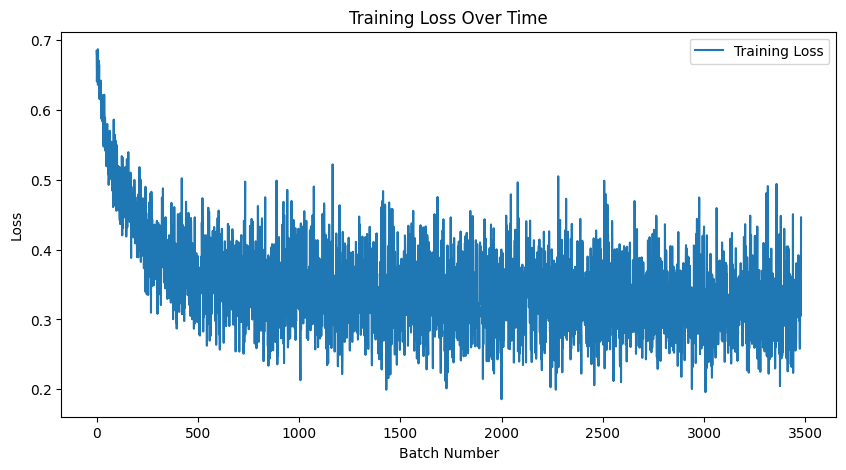

In [36]:
n_epochs = 15

# Your solution here ###########################################################

all_losses = []

for epoch in range(n_epochs):
  epoch_losses = []

  for batch in loader_train:
    optimizer.zero_grad
    input, label = batch

    loss = train_nn_step(optimizer, loss_fn, mlp, input.to(device), label.to(device))
    epoch_losses.append(loss)
  all_losses.extend(epoch_losses)
  print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {sum(epoch_losses)/len(epoch_losses)}")

plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**1.3.7 [1pts]** Evaluate the trained model on both the training and test data, using the most relevant metric from those already imported from TorchMetrics.

In [ ]:
# Your solution here ###########################################################

metric_fn = BinaryF1Score().to(device)

metric_tr = eval_nn(mlp, loader_train, metric_fn)
metric_te = eval_nn(mlp, loader_test, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

**1.3.8 [3pts]** Try different hyperparameters' combinations, in particular for the hidden dimension of the MLP and the learning rate of the optimizer. Then discuss the obtained results and the learning curves.

**Your answer here:**

**Your answer here:**

In order to finetune the hyperparameters (the learning rate and the number of hidden features), a (manual) grid search was performed, yielding the following results (F1-scores):

**Train**

| lr/h | 32    | 64    | 128   | 256   | 512   |
|------|-------|-------|-------|-------|-------|
| **1e-3** | 0.922 | 0.935 | 0.951 | 0.960 | 0.972 |
| **1e-4** | 0.910 | 0.910 | 0.912 | **0.914** | 0.918 |
| **1e-5** | 0.893 | 0.892 | 0.899 | 0.903 | 0.905 |

**Test**

| lr/h | 32    | 64    | 128   | 256   | 512   |
|------|-------|-------|-------|-------|-------|
| **1e-3** | 0.905 | 0.901 | 0.892 | 0.899 | 0.887 |
| **1e-4** | 0.910 | 0.910 | 0.909 | **0.911** | 0.909 |
| **1e-5** | 0.896 | 0.894 | 0.905 | 0.906 | 0.907 |

Looking at these tables we can clearly see that the optimal pair is ($lr=\text{1e-4},~h = 256$). For a learning rate of 1e-3 we can see a clear overfit especially when the number of hidden features increases and the complexity of the model increases.

### Question 1.4: Graph Neural Networks (20 points)

We will now shift from the standard deep learning paradigm to Graph Neural Networks, to leverage the additional structure of our data.

We already imported [PyTorch Geometric][torch_geometric] as `pyg`, so you can access its submodules as `pyg.nn`, `pyg.data` and so on.

[torch_geometric]: https://pytorch-geometric.readthedocs.io/en/latest/index.html

**1.4.1 [2pts]** Let's start by defining our first GNN. Again, it will be a subclass of the PyTorch `Module`, but this time it will take into account the `edge_index` in its `forward method`. Use two [GCN layers][gcn] to go from input features, here called *channels*, to a hidden dimension defined in the constructor, then to logit readout. Use ReLU activations.

This GNN will map node vectors to node logits, so we can directly read out node probabilities from

[gcn]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html

In [ ]:
class GCN(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
      super(GCN, self).__init__()
      self.conv = pyg.nn.GCNConv(in_channels, hidden_channels)
      self.linear = nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index):
      x = self.conv(x, edge_index).relu()
      x = self.linear(x)

      return x
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.2 [3pts]** Perform `n_epochs` of training of a GCN model with 64 hidden channels, using full training data as a batch. Make sure to only use training data in the loss computation by using the `train_mask`. Track the loss value at each step and plot it. Finally, evaluate the model on train and test, using the `metric_fn` from before.

In [ ]:
# Your solution here ###########################################################

in_features = n_feats
hidden_features = 64
learning_rate = 1e-3

gcn = GCN(in_channels=in_features, hidden_channels=hidden_features).to(device)

optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
edge_index = data.edge_index.to(device)

n_epochs = 100
loss_values = []

for epoch in range(n_epochs):
  optimizer.zero_grad()

  out = gcn(data.x.to(device), data.edge_index.to(device))

  loss = loss_fn(out[train_mask].to(device), data.y[train_mask].to(device))

  loss.backward()
  optimizer.step()

  loss_values.append(loss.item())
  if epoch % 9 == 0:
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

def evaluate(model, features, edge_index, mask, metric_fn):
    model.eval()
    with torch.no_grad():
        preds = model(features, edge_index).argmax(dim=-1)
        preds = preds[mask]
        labels = data.y[mask].to(device)
        metric_fn(preds.to(device), labels.to(device))
        metric_value = metric_fn.compute()
        metric_fn.reset()
        return metric_value

metric_fn = BinaryF1Score().to(device)
metric_tr = evaluate(gcn, data.x.to(device), data.edge_index.to(device), train_mask, metric_fn)
metric_te = evaluate(gcn, data.x.to(device), data.edge_index.to(device), ~train_mask, metric_fn)

plt.plot(loss_values)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

**1.4.3 [2pts]** Hopefully, we got already some good results, but we would like to test whether stochastic optimization might be better. Batching graph data requires a particular approach, since on top of the design matrix with node features we have to account for edge information. In our setting, we have a single graph with many nodes, and a node level task. A batching strategy consists in sampling nodes with their neighbors, then working with this smaller graphs in a batched way.

Define one [NeighborLoader][neighborloader] for the training data, which will gather neighbors for as many *iterations* as layers in your GCN.

References:
- [Mini batches](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#mini-batches)

[neighborloader]: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader

In [ ]:
batch_size = 1024

# Your solution here ###########################################################

loader_graph_train = pyg.loader.NeighborLoader(
    data,
    input_nodes=train_mask,
    num_neighbors=[30]*2,
    batch_size=batch_size,
    shuffle=True,
)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.4 [1pt]** Use the previously defined `train_nn_step` to train a newly initialized GCN with the new loader. Again plot the loss evolution and evaluate the trained model on train and test data.

In [ ]:
# Your solution here ###########################################################

in_features = n_feats
hidden_features = 64
learning_rate = 1e-3

gcn = GCN(in_channels=in_features, hidden_channels=hidden_features).to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

n_epochs = 100
all_losses = []
for epoch in range(n_epochs):
  epoch_loss = 0
  for batch in loader_graph_train:
    loss = train_nn_step(optimizer, loss_fn, gcn, batch.x.to(device), batch.y.to(device), is_gcn=True, edge_idx=batch.edge_index.to(device))
    epoch_loss += loss
  avg_loss = epoch_loss / len(loader_train)
  all_losses.append(avg_loss)
  if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution During Training')
plt.legend()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**1.4.5 [1pts]** Predict the label probabilities of each node and evaluate.

In [ ]:
# Your solution here ###########################################################

def evaluate(model, loader, metric_fn):
  model.eval()
  metric_fn.reset()
  with torch.no_grad():
    for batch in loader:
      batch.to(device)
      preds = model(batch.x, batch.edge_index).argmax(dim=1)
      metric_fn.update(preds, batch.y)
  return metric_fn.compute()

loader_graph_test = pyg.loader.NeighborLoader(
    data,
    num_neighbors=[30]*2,
    input_nodes=~train_mask,
    batch_size=batch_size,
    shuffle=False,
)

metric_fn = BinaryF1Score().to(device)
metric_tr = evaluate(gcn, loader_graph_train, metric_fn)
metric_te = evaluate(gcn, loader_graph_test, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

**1.4.6 [2pts]** Define a new GNN architecture using [graph attention layers][gat].

[gat]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATv2Conv.html#torch_geometric.nn.conv.GATv2Conv

In [ ]:
class GAT(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
      super(GAT, self).__init__()
      self.conv = pyg.nn.GATv2Conv(in_channels, hidden_channels)
      self.linear = nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index):
      x = self.conv(x, edge_index).relu()
      x = self.linear(x)

      return x
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.7 [3pts]** Train and evaluate the GAT model with both methods.

In [ ]:
def full_training(model, optim, loss_fn, n_epochs, verbose=False):

  loss_values = []

  for epoch in range(n_epochs):
    optim.zero_grad()

    out = model(data.x.to(device), data.edge_index.to(device))

    loss = loss_fn(out[train_mask].to(device), data.y[train_mask].to(device))

    loss.backward()
    optim.step()

    loss_values.append(loss.item())

    if (epoch + 1) % 10 == 0 and verbose:
      print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

  return loss_values

def batch_training(model, optim, loss_fn, n_epochs, verbose=False):

  loss_values = []

  for epoch in range(n_epochs):
    epoch_loss = 0
    for batch in loader_graph_train:
      loss = train_nn_step(optim, loss_fn, model, batch.x.to(device), batch.y.to(device), is_gcn=True, edge_idx=batch.edge_index.to(device))
      epoch_loss += loss
    avg_loss = epoch_loss / len(loader_train)
    loss_values.append(avg_loss)
    if (epoch + 1) % 10 == 0 and verbose:
      print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")

    return loss_values

def evaluate_ft(model, features, edge_index, mask, metric_fn):
    model.eval()
    with torch.no_grad():
        preds = model(features, edge_index).argmax(dim=-1)
        preds = preds[mask]
        labels = data.y[mask].to(device)
        metric_fn(preds, labels)
        metric_value = metric_fn.compute()
        metric_fn.reset()
        return metric_value


def evaluate_bt(model, loader, metric_fn):
  model.eval()
  metric_fn.reset()
  with torch.no_grad():
    for batch in loader:
      batch.to(device)
      preds = model(batch.x, batch.edge_index).argmax(dim=1)
      metric_fn.update(preds, batch.y)
  return metric_fn.compute()

In [ ]:
print("FULL TRAINING")

# Your solution here ###########################################################

in_features = n_feats
hidden_features = 128
learning_rate = 1e-3
n_epochs = 100

gat = GAT(in_channels=in_features, hidden_channels=hidden_features).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

loss_values_ft = full_training(
    model=gat,
    optim=optimizer,
    loss_fn=loss_fn,
    n_epochs=n_epochs,
)

metric_fn = BinaryF1Score().to(device)
metric_tr = evaluate_ft(gat, data.x.to(device), data.edge_index.to(device), train_mask, metric_fn)
metric_te = evaluate_ft(gat, data.x.to(device), data.edge_index.to(device), ~train_mask, metric_fn)

plt.plot(loss_values_ft)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.title("Full training")
plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

print("BATCH TRAINING")

# Your solution here ###########################################################

in_features = n_feats
hidden_features = 512
learning_rate = 1e-3
n_epochs = 100

gat = GAT(in_channels=in_features, hidden_channels=hidden_features).to(device)
optimizer = torch.optim.Adam(gat.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

loss_values_bt = full_training(
    model=gat,
    optim=optimizer,
    loss_fn=loss_fn,
    n_epochs=n_epochs,
)

metric_fn = BinaryF1Score().to(device)
metric_tr = evaluate_bt(gat, loader_graph_train, metric_fn)
metric_te = evaluate_bt(gat, loader_graph_test, metric_fn)

plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

plt.title("Full training")
plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

**1.4.8 [6pts]** Compare the results of these two architectures, with multiple hyperparameters, and the previous results. Discuss the eventual differences in performance highlighting the properties that you believe influence most the outcome.

In [ ]:
# Runtime: ~10min with GPU
import itertools

print("FULL TRAINING")

in_features = n_feats

h_list = [64, 128, 256, 512]
lr_list = [1e-4, 1e-3, 1e-2]
n_epochs = [50, 100, 150]

train_f1_ft = {}
test_f1_ft = {}

for n, lr, h in itertools.product(n_epochs, lr_list, h_list):
  print(f'({n = }, {lr = }, {h = })')
  gat = GAT(in_channels=in_features, hidden_channels=h).to(device)
  optimizer = torch.optim.Adam(gat.parameters(), lr=lr)
  loss_fn = torch.nn.CrossEntropyLoss().to(device)

  loss_values_ft = full_training(
      model=gat,
      optim=optimizer,
      loss_fn=loss_fn,
      n_epochs=n,
      verbose=False,
  )

  metric_fn = BinaryF1Score().to(device)
  metric_tr = evaluate_ft(gat, data.x.to(device), data.edge_index.to(device), train_mask, metric_fn)
  metric_te = evaluate_ft(gat, data.x.to(device), data.edge_index.to(device), ~train_mask, metric_fn)

  train_f1_ft[f'({n = }, {lr = }, {h = })'] = metric_tr.item()
  test_f1_ft[f'({n = }, {lr = }, {h = })'] = metric_te.item()

print("BATCH TRAINING")

in_features = n_feats

hidd_dims_list = [32, 64, 128, 256, 512]
lr_list = [1e-5, 1e-4, 1e-3]
n_epochs = [50, 100, 150]

train_f1_bt = {}
test_f1_bt = {}

for n, lr, h in itertools.product(n_epochs, lr_list, h_list):
  print(f'({n = }, {lr = }, {h = })')
  gat = GAT(in_channels=in_features, hidden_channels=h).to(device)
  optimizer = torch.optim.Adam(gat.parameters(), lr=lr)
  loss_fn = torch.nn.CrossEntropyLoss().to(device)

  loss_values_bt = batch_training(
      model=gat,
      optim=optimizer,
      loss_fn=loss_fn,
      n_epochs=n,
      verbose=False,
  )

  metric_fn = BinaryF1Score().to(device)
  metric_tr = evaluate_bt(gat, loader_graph_train, metric_fn)
  metric_te = evaluate_bt(gat, loader_graph_test, metric_fn)

  train_f1_bt[f'({n = }, {lr = }, {h = })'] = metric_tr.item()
  test_f1_bt[f'({n = }, {lr = }, {h = })'] = metric_te.item()


In [ ]:
top_test_ft = sorted(test_f1_ft.items(), key=lambda x: x[1], reverse=True)[:5]
top_train_ft = sorted(train_f1_ft.items(), key=lambda x: x[1], reverse=True)[:5]
top_test_bt = sorted(test_f1_bt.items(), key=lambda x: x[1], reverse=True)[:5]
top_train_bt = sorted(train_f1_bt.items(), key=lambda x: x[1], reverse=True)[:5]

print("Full Training")
for i, (k, v) in enumerate(top_test_ft):
  print(f"\tTop {i+1} test full training: {k} -> {v:.3f}")

for i, (k, v) in enumerate(top_train_ft):
  print(f"\tTop {i+1} train full training: {k} -> {v:.3f}")

print("Batch Training")
for i, (k, v) in enumerate(top_test_bt):
    print(f"\tTop {i+1} test batch training: {k} -> {v:.3f}")

for i, (k, v) in enumerate(top_train_bt):
    print(f"\tTop {i+1} train batch training: {k} -> {v:.3f}")

**Your answer here:**

**Your answer here:**

Looking at the above f1-scores comparing **full training** and **batch training** for various values of their hyperparameters (n: number of epochs, h: hidden dimensions, lr: learning rate), we kept the model simple in order to facilitate the tunning (potential hyperparameters to consider: dropout rate, batch normalization, number of attention heads etc.).
- **Test F1-Score:** The best scores for full training and batch training are 0.9147 and 0.9172 respectively. The batch training is generalizes slightly better, but no great difference.

- **Train F1-Score:** Full training are generally higher compared to batch training, achieving 0.9995 and 0.9177 respectively. These significantly greater scores in the training compared to the testing indicate overfitting on the train set for the full training.

**Influence of hyperparameters**
- **Hidden Units:** Higher number of hidden units result in higher performances. Increased complexity, can capture more complex patterns in the data, enhancing performance. However if a model is too complex it can lead to overfitting.
- **Learning Rate:** All top performing models were using a learning rate of 1e-3. This learning rate seems to provide a good balance between convergence speed and stability.
-**Number of epochs:** Larger batch sizes lead to some of the highest F1-scores, however the score seem to peek at 100 epochs and then saturate.

**Conclusion**

- Batch training has better generalization.
- The optimal hyperparameters for each model are:
  - Full train: (n = 100, lr = 1e-3, h = 128)
  - Batch train: (n = 100, lr = 1e-3, h = 512)


## Part 2: Learning graphs [20 points]

Graph attention layers are quite interesting, since they use the local and the incoming information of a node to give different weights to each neighbor. This is conceptually similar to learning a new graph on top of the existing one.

In this part, we design a block that, from node embeddings, will produce a new graph. The idea is similar to the one in the paper "Discrete Graph Structure Learning for Forecasting Multiple Time Series", which is illustrated in the following Figure.

References:
- C. Shang, J. Chen, and J. Bi, “Discrete Graph Structure Learning for Forecasting Multiple Time Series,” presented at the International Conference on Learning Representations, Feb. 2022. Accessed: Aug. 15, 2022. Available: https://openreview.net/forum?id=WEHSlH5mOk




![Graph Learning Module](graph_learning_module.png)

As we can see from the schema, we have three main components:
1. **Feature extractor**: mapping each node to a new, synthesized representation;
2. **Link predictor**: for each pair of node representations, predict the probability that an edge links them. We gather probabilities in a *structure matrix* $\theta$;
3. **Sampling**: Sample one, or multiple, discrete graphs from the structure matrix.

In the following questions, we will break down these components.

### Question 2.1: Sampling (4 points)

Sampling is the most intriguing part of our module, as it maps, randomly, continuous probabilities to discrete edges.
Ideally, we would like to sample each edge with a probability $\theta$, following a Bernoulli distribution, but this would be hard to backpropagate through.

What we do instead is known as the **Gumbel Trick**.
We sample edges using a [Gumbel][gumbel] reparameterization, which allows differentiating for $\theta$ through it. With $g_{ij}^1, g_{ij}^2 \sim \operatorname{Gumbel}(0,1)$ for all $i,j$, and $s$ a temperature parameter,
$$
A_{ij} = \operatorname{sigmoid}\left(
  \frac{
    \log\left( \frac{\theta_{ij}}{1 - \theta_{ij}} \right)
    + g_{ij}^1 - g_{ij}^2
  }{s}
\right)
.
$$
By letting the temperature go to zero, we can get closer and closer to a Bernoulli distribution.

[gumbel]: https://en.wikipedia.org/wiki/Gumbel_distribution


**2.1.1 [2pts]** Define a function to sample a matrix of Gumbel variables of given shape, knowing that, for $p$ sampled uniformly in (0,1), then $Q(p) \sim \operatorname{Gumbel}(\mu,\beta)$
$$
  Q(p)=\mu-\beta \ln (-\ln (p))
  .
$$

In [9]:
def sample_gumbel(shape, mu=0, beta=1):
    # Your solution here #######################################################
    p = torch.rand(shape).clamp(min=1e-5)#np.random.uniform(low=0, high=1, size=shape)
    return mu - beta * np.log(-np.log(p))
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing sample_gumbel")
print(sample_gumbel((2, 3), 0, 1))

Testing sample_gumbel
tensor([[-0.9373, -0.8316,  2.5175],
        [ 2.5165, -1.0509, -0.8342]])


**2.1.2 [2pts]** Note that $log(\frac{\theta}{1 - \theta})$ is the sigmoid function, so we can work with unnormalized edge logits instead of probabilities. Define a function to sample an adjacency matrix $A$ from edge logits using the Gumbel Trick.

In [10]:
def sample_gumbel_trick(logits, temperature, mu=0, beta=1):
    # Your solution here #######################################################
    g1 = sample_gumbel(logits.shape, mu, beta)
    g2 = sample_gumbel(logits.shape, mu, beta)

    x = (logits + g1 - g2) / temperature

    return torch.sigmoid(x)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing sample_gumbel_trick")
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=10))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1e-2))

Testing sample_gumbel_trick
tensor([1.0000, 0.4548, 0.4841, 0.2337])
tensor([1.0000e+00, 4.4558e-01, 7.1567e-01, 4.2694e-05])
tensor([1.0000, 1.0000, 0.9999, 0.0000])


### Question 2.2: Link predictor (11 points)

GNNs are all about node embeddings, which by now we should know how to deal with. The missing component is therefore the **link predictor**.

Naively, we could iterate through all pairs of nodes and apply a predictor layer, but it would be highly inefficient.
To leverage tensor manipulation, let's start by gathering paired node representations in a matrix, so that we can predict probabilities in parallel.

**2.2.1 [3pts]**  Define a function that takes as input a tensor of node embeddings, and returns a tensor that concatenate embeddings pairwise. Use [triu_indices][triu_indices] to have pairs appearing only once and avoid self loops, and return the indices along with the embeddings.

[triu_indices]: https://pytorch.org/docs/stable/generated/torch.triu_indices.html

In [11]:
def pair_embeddings(x) -> (torch.Tensor, torch.Tensor):
    # Your solution here ###########################################################
    n = x.size(0)

    # Get upper triang indices (without diagonal)
    triu_indices = torch.triu_indices(n, n, offset=1)

    node_pairs = torch.cat((x[triu_indices[0]], x[triu_indices[1]]), dim=1)

    return node_pairs, triu_indices
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing pair_embeddings")
print(pair_embeddings(torch.tensor([[1.0], [2.0], [3.0]]))[0])
print(pair_embeddings(torch.tensor([[[1.0], [2.0], [3.0]], [[4.0], [5.0], [6.0]]]))[0])

Testing pair_embeddings
tensor([[1., 2.],
        [1., 3.],
        [2., 3.]])
tensor([[[1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.]]])


**2.2.2 [8pts]** Define a PyTorch module that takes as input node embeddings, compute link probabilities with a two-layer perceptron on paired embeddings, then samples edges with the Gumbel trick. The output of the forward method will be a PyTorch Geometric [EdgeIndex][edge_index] of tensors representing indices and weights corresponding to positively sampled edges. You might need a `eps` threshold to avoid numerical errors.

[edge_index]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.edge_index.EdgeIndex

In [23]:
class MLPGraphLearn(nn.Module):
    # Your solution here ###########################################################
    def __init__(
        self, in_features: int, hidden_features: int, temperature: float, eps=1e-10
    ): 
        super(MLPGraphLearn, self).__init__()
        self.temp = temperature
        self.eps = eps
        self.fc1 = nn.Linear(2*in_features, hidden_features) # 2 inputs per edge
        self.fc2 = nn.Linear(hidden_features, 1)

    def forward(self, x):
        n = x.squeeze().size(0)
        
        node_pairs, indices = pair_embeddings(x.squeeze())
        
        x = self.fc1(node_pairs).relu()

        logits = self.fc2(x).squeeze(-1)

        edge_probs = sample_gumbel_trick(logits, self.temp)

        mask = edge_probs > self.eps
        edge_indices = indices[:, mask]
        edge_index = pyg.EdgeIndex(edge_indices, sparse_size=(n, n), is_undirected=True)


        return edge_index
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing MLPGraphLearn")
mlp_gl = MLPGraphLearn(2, 5, 0.01)
mlp_gl(torch.tensor([[[1.0, 2.0], [0.5, 7.1], [-0.1, 0.3]]]))

Testing MLPGraphLearn
x.squeeze().size(0) = 3


EdgeIndex([[0, 1],
           [2, 2]], sparse_size=(3, 3), nnz=2, is_undirected=True)

### Question 2.3: Classifiers with Graph Learning Module (5 points)

Let's introduce our graph learning block into some classifiers.


**2.3.1 [4pts]** Define a classifier that first produces node embeddings with a Linear layer with ReLU activation, which it feeds to the previously defined GL module; then it performs two graph convolutions on the original node features using the learned graph.

In [18]:
class MLPGLClassifier(nn.Module):
    # Your solution here #######################################################
    def __init__(
        self,
        in_features: int,
        gl_node_features_in: int = 64,
        gl_node_features_hidden: int = 32,
        gcn_hidden: int = 64,
    ):
        super(MLPGLClassifier, self).__init__()
        self.linear = nn.Linear(in_features, gl_node_features_in)
        self.relu = nn.ReLU()

        self.gl = MLPGraphLearn(gl_node_features_in, gl_node_features_hidden, temperature=0.1)

        self.gcn1 = pyg.nn.GCNConv(in_features, gcn_hidden)
        self.gcn2 = pyg.nn.GCNConv(gcn_hidden, gcn_hidden)

    def forward(self, data):
        x = data.x

        embeddings = self.relu(self.linear(x))
        learned_ei = self.gl(embeddings)

        x = self.gcn1(x, learned_ei).relu()
        x = self.gcn2(x, learned_ei)
        
        return torch.log_softmax(x, dim=1)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**2.3.2 [1pt]** Unfortunately, training and evaluating the `MLPGLClassifier` might take too long. Let's just test whether it works: instantiate the classifier and compute the graph embedding.

In [19]:
# Your solution here ###########################################################
num_nodes = 4
n_feats = 10

node_features = torch.rand((num_nodes, n_feats))

# Fully connected graph minus self-connections
edge_index = torch.tensor([[0, 1, 2, 0, 1, 3, 0, 2, 1, 2, 3, 3],
                           [1, 0, 0, 2, 2, 1, 3, 3, 3, 1, 0, 2]], dtype=torch.long)

# Create a data object
test_data = pyg.data.Data(x=node_features, edge_index=edge_index)

mlpg_clf = MLPGLClassifier(in_features=n_feats).to(device)

with torch.no_grad():
    output = mlpg_clf(test_data)
    print("Graph embedding computed successfully.")
    print("Output shape:", output.shape)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

x.shape = torch.Size([4, 64])
Graph embedding computed successfully.
Output shape: torch.Size([4, 64])


## Part 3 (Theory): Forcing causal structure in learned graphs [35 points]

Understanding and mapping the causal relationships among data variables, represented by directed acyclic graphs (DAGs), presents a significant challenge. The search space for these DAGs is combinatorial, and it scales super exponentially with the number of nodes, further complicating the task.

Assuming causal relationships between data variables, the basic DAG learning problem is formulated as follows: Let $\mathbf{X} \in \mathbb{R}^{n \times d}$ be a data matrix consisting of $n$ i.i.d. observations of the random vector $x=\left(x_1, \ldots, x_d\right)$ and let $\mathbb{D}$ denote the (discrete) space of DAGs $\mathrm{G}=(\mathrm{V}, \mathrm{E})$ on $d$ nodes. Given $\mathbf{X}$, we seek to learn a DAG $\mathrm{G}$ represented by its adjacency matrix $A$ such that:

$$
\begin{array}{rl}
\min _{A \in \mathbb{R}^{d \times d}} &  F(A):= \frac{1}{2 n}\|\mathbf{X}-GNN(\mathbf{X}, A)\|_F^2+\lambda\|A\|_1 \\
\text { subject to } &  A \in \mathbb{D} ,
\end{array}
$$
where $\mathbb{D}$ represents a DAG space and GNN is a graph neural network that simultaneously learns a DAG $A$ and accurately predicts an estimation of the matrix $\mathbf{X}$. The minimization of the aforementioned problem guides us towards finding the causal graph that generates the data $\mathbf{X}$. Although $F(A)$ is continuous, the DAG constraint $A \in \mathbb{D}$ remains a challenge to enforce.

The objective is to make the aforementioned problem amenable to black-box optimization (in order to use SGD, ADAM...). We aim to replace the combinatorial acyclicity constraint $A \in \mathbb{D}$ with a single smooth equality constraint $h(A) = 0$. Thus, the objective of this section is to find a smooth function $h: \mathbb{R}^{d \times d} \rightarrow \mathbb{R}$ that will satisfy the following: $h(A)=0$ if and only if $A$ is acyclic (i.e. $A \in \mathbb{D}$). Furthermore, we want to ensure that $h$ and its derivatives are easy to compute.

### Question 3.1: DAGness property for binary matrix with spectral radius condition (8 points)

In this question we want to find out when a matrix $A \in\{0,1\}^{d \times d}$ corresponds to an acyclic graph.

Suppose $A \in\{0,1\}^{d \times d}$ and $r(A)<1$, $r(A)$ is the spectral radius of the matrix $A$, and it corresponds to the largest absolute eigenvalue of $A$.



**3.1.1 [2pts]** Justify the convergence of $\sum_{k=0}^{\infty} A^k$ and show that:
$$\left(I_n-A\right)^{-1}=\sum_{k=0}^{\infty} A^k$$

**Your answer here:**

We denote $I_d$ with $I$. It suffices to show that:

$$I = \left(\sum_{k \geq 0}A^k\right)(I -A) = (I-A)\left(\sum_{k \geq 0}A^k\right).$$

Fix an arbitrary $m \in \mathbb{N}$. We have that:

$$\begin{cases}
\sum_{0\leq k \leq  m}A^k=I + A + \dots + A^m\\\sum_{0 \leq k \leq m}A^{k+1}=A+A^2+\dots+A^{m+1}.
\end{cases}$$

Subtracting the second from the first we get:

$$\sum_{0\leq k \leq  m}A^k-\sum_{0 \leq k \leq m}A^{k+1}=I - A^{m+1},$$

or equivalently:
$$\begin{cases}
\left(\sum_{0\leq k \leq m}A^k\right)(I -A)=I - A^{m+1}\\(I -A)\left(\sum_{0\leq k \leq m}A^k\right)=I - A^{m+1}.
\end{cases}$$

Thus, it suffices to show that:

$$\lim_{m \to ∞}A^m=0.$$

Consider the Jordan decomposition of $A=PJP^{-1}$. It is easy to see that $A^m=PJ^mP^{-1}$. We conclude by showing that $\lim_{m \to ∞}J^m=0$. Note that $J^m$ is block diagonal matrix whose blocks are upper triangular matrices with $\lambda^m$ (where $\lambda$ is an eigenvalue of $A$) on the diagonal and elements of the form $m^{O(1)}\lambda^{O(m)}$ above the diagonal. Thus, every element of each block goes to 0 as $m\to ∞$ (since the spectral radius of $A$ is strictly smaller than 1)

**3.1.2 [6pts]** Show that $A$ is a $D A G$ if and only if $\operatorname{tr}(I-A)^{-1}=d$

**Your answer here:**

For a vertex $i$, let $c_i$ denote the number of cycles starting and ending in $i$. Thus, $A \in \mathbb{D}$ if and only if $c_i=0, \forall i \in V$. By definition of $A$, we have that $c_i = \sum_{k \geq 1} (A^k)_{i,i}$. From the previous question, we can write:

$$
\begin{align*}
Tr\left((I-A)^{-1}\right)&=Tr\left(\sum_{k \geq 0}A^k\right) \\ &=Tr(I) + Tr\left(\sum_{k \geq 1}A^k\right) \\
&= d + \sum_{i \in [d]}\sum_{k \geq 1}(A^k)_{i,i}
\\&= d + \sum_{i \in [d]}c_i \\&\geq d.
\end{align*}
$$

Thus, we directly get that:

$$A \in \mathbb{D} \iff \sum_{i \in [d]}c_i = 0 \iff Tr\left((I-A)^{-1}\right)=d.$$

Having an assumption on $r(A) < 1$ limits the application of our results. For this reason, our objective is to generalize the previous result to binary matrices.


### Question 3.2: DAGness property for binary matrix (8 points)

Suppose $A \in\{0,1\}^{d \times d}$.

**3.2.1 [4pts]**  Prove the existence of the exponential matrix, we recall that $e^{A} = \sum_{k=0}^{\infty} \frac{A^k}{k !}$


**Your answer here:**

Note that $\mathbb{R}^{d \times d}$ is a finite-dimensional normed vector space. We use the following two facts without a proof:
1.   Every finite-dimensional normed space $X$ is a Banach space, which in particular means that every absolutely convergent series in $X$ is also convergent.
2.   Any two norms $\|\cdot\|_\alpha, \|\cdot\|_\beta$ on a finite-dimensional space $X$ are topologically equivalent, i.e. $$\exists c_1, c_2 \in \mathbb{R}_{>0}: c_1 \|v\|_\alpha\leq \|v\|_\beta \leq c_2 \|v\|_\alpha, \forall v \in X.$$

From the above, we know that $\mathbb{R}^{d \times d}$ is a Banach space, which in particular implies that for any matrix norm $\|\cdot\|$ we have:
$$\sum_{k \geq 0}\left\|\frac{A^k}{k!}\right\| < ∞\implies \sum_{k \geq 0}\frac{A^k}{k!} < ∞.$$
Thus, we only need to prove the antecedent of the above implication. From fact (2) above, we are free to choose any matrix norm. We consider a sub-multiplicative matrix norm, say the Frobenius norm $\|\cdot\|_F$. By the sub-multiplicativity and the absolute homogeneity of the Frobenius norm, we have that:
$$\sum_{k \geq 0}\left\|\frac{A^k}{k!}\right\|_F\leq \sum_{k \geq 0}\frac{\left\|A\right\|^k_F}{k!} < ∞,$$
since $\forall x \in \mathbb{R}, e^x=\sum_{k \geq 0}\frac{x^k}{k!} \in \mathbb{R}$ and $\left\|A\right\|_F \in \mathbb{R}$. This concludes the proof. QED

**3.2.2 [4pts]** Show that $A$ is a $D A G$ if and only if $\operatorname{tr} e^A=d$, where $e^A$ is the exponential matrix.

**Your answer here:**

Similarly to Question 3.1.2, we have that:
$$
\begin{align*}
Tr\left(e^A\right)&=Tr\left(\sum_{k \geq 0}\frac{A^k}{k!}\right) \\ &=Tr(I) + Tr\left(\sum_{k \geq 1}\frac{A^k}{k!}\right) \\
&= d + \sum_{i \in [d]}\sum_{k \geq 1}\left(\frac{A^k}{k!}\right)_{i,i}
\\ &\stackrel{A \geq 0}{\geq} d.
\end{align*}
$$

Now, it's easy to see that: $$A \in \mathbb{D} \iff (A^k)_{i,i} = 0, \forall i \in V, k \geq 1 \stackrel{A \geq 0}{\iff} \sum_{i \in [d]}\sum_{k \geq 1}\left(\frac{A^k}{k!}\right)_{i,i}= 0\iff Tr\left(e^A\right)=d.$$

**3.3 [5pts]** DAGness property for weighted adjacency matrices

Suppose $A \in \mathbb{R}^{d \times d}$. Knowing that the equivalence of Question 3.2 is correct for any nonnegative weighted matrix $A$, propose a function $f$ such that $A$ is a $D A G$ if and only if $\operatorname{tr} e^{f(A)}=d$.


**Your answer here:**

We are looking for a function $f: \mathbb{R}^{d \times d} \to \mathbb{R}^{d \times d}_{\geq 0}$ such that the unweighted counterparts of graphs $A$ and $f(A)$ (note that there is a bijection between node-labeled directed graphs and real square matrices) are isomorphic. The simplest way to achieve this is to square the weight of every edge, i.e. we take $f(A)=A \circ A$ (where $\circ$ denotes the Hadamard product). This way, we exactly preserve the edges and the non-edges of the graph $A$. Since $A \sim f(A)$ (simply consider the identity function on $V$, here we consider any non-zero weight as being equal to 1), we get that:
$$A \in \mathbb{D} \iff f(A) \in \mathbb{D} \stackrel{f(A) \geq 0}{\iff} Tr(e^{f(A)})=d,$$
where the last equivalence was proven in the above question.

**3.4 [7pts]** Compute the gradient of $h(A) = \operatorname{tr} e^{f(A)}-d$.

**Your answer here:**

We need to compute: $\nabla_{A} (Tr(e^{A \circ A})-d)=\nabla_{A} Tr(e^{A \circ A})$. Set $B=A\circ A$. We have that: $$\nabla_{A} Tr(e^{A \circ A})=(\nabla_{B} Tr(e^{B})) \circ (\nabla_{A} (A \circ A)).$$
We compute the two gradients separately:
1.   For the second gradient we have:
$$\nabla_{A} (A \circ A)=2A.$$
2.   For the first gradient, using the linearity of the Trace operator, we have that:
$$
\begin{align*}
\nabla_{B} Tr(e^{B}) &=\nabla_{B} Tr\left(\sum_{k \geq 0}\frac{B^k}{k!}\right)\\&=\nabla_{B} Tr\left(\sum_{k \geq 0}\frac{B^k}{k!}\right)\\ &=\sum_{k \geq 0}\frac{\nabla_B Tr(B^k)}{k!}\\ &= 0_{d} + \sum_{k \geq 1}\frac{k\cdot (B^{k-1})^T}{k!} \\ &= \sum_{k \geq 1}\frac{(B^{k-1})^T}{(k-1)!}\\ &=\sum_{k \geq 0}\frac{(B^{k})^T}{k!}=(e^B)^T=(e^{A \circ A})^T,
\end{align*}
$$
where we used $0_d$ to denote the $d$-by-$d$ zero matrix. Note that we have used the following fact:

$$\nabla_XTr(X^k)=k\cdot (X^{k-1})^T, \forall k \in \mathbb{N}, X \in \mathbb{R}^{n\times n}$$

Thus, overall we get that: $$\nabla_{A} (Tr(e^{A \circ A}) - d) = (e^{A \circ A})^T \circ 2A.$$

**3.5 [7pts]** Other alternatives

Suppose $A \in \mathbb{R}^{d \times d}$. For the previously proposed function $f$ show that for any $\alpha > 0 $, $A$ is a $D A G$ if and only if $\operatorname{tr}\left[(I+\alpha f(A))^d\right]-d=0.$

**Your answer here:**

Note that $I$ and $\alpha(A \circ A)$ commute with respect to multiplication. Thus, from the binomial theorem we get that: $$(I + \alpha (A \circ A))^d=\sum_{0 \leq k \leq d}I^{d-k}(\alpha(A \circ A))^k=\sum_{0 \leq k \leq d}(\alpha(A \circ A))^k.$$

Thus, we get that:
$$\begin{align*}
Tr\left((I + \alpha (A \circ A))^d\right)&=Tr\left(\sum_{0 \leq k \leq d}(\alpha(A \circ A))^k\right) \\&= \sum_{0 \leq k \leq d}Tr\left((\alpha(A \circ A))^k\right) \\ &=\sum_{0 \leq k \leq d}Tr\left((\alpha(A \circ A))^k\right) \\ &=d + \sum_{1 \leq k \leq d}\alpha^kTr\left((A \circ A)^k\right)
\end{align*}.
$$

Now $\alpha >0$ and $A\circ A \geq 0$ imply that:
$$\sum_{1 \leq k \leq d}\alpha^kTr\left((A \circ A)^k\right) \geq 0$$ 
and it's easy to see that: $$\sum_{1 \leq k \leq d}\alpha^kTr\left((A \circ A)^k\right) > 0\iff A \notin \mathbb{D}.$$